## Lotka-Volterra 1 predator 1 prey test

### Roe Deer and Wolf

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Roe deer and wolf
alpha = 9/11 # Birth rate prey 
beta = 48.6 / 365.25 # Death rate prey
gamma = 0.0356 # Birth rate predator
delta = 25/26 # Death rate predator

# Time * step = amount of years
time = 1000000
step = 0.0001

pred_name = 'wolf'
prey1_name = 'roe deer'

# Initial populations
init_pred = 10
init_prey1 = 110

# Differential equation predator population
def pred_eq(gamma, delta, w, r, step):
    return step * w * (gamma*r - delta) 

# Differential equation prey population
def prey1_eq(alpha, beta, w, r, step):
    return step * r * (alpha - beta*w)

In [119]:
# Initialize arrays for number of animals in populations
pred = [init_pred]
prey1 = [init_prey1]

num_pred = init_pred
num_prey1 = init_prey1

# Update the number of animals time times and store them in arrays
for n in range(time):
    dpred = pred_eq(gamma, delta, num_pred, num_prey1, step)
    dprey1 = prey1_eq(alpha, beta, num_pred, num_prey1, step)
    num_pred += dpred
    num_prey1 += dprey1
    pred.append(num_pred)
    prey1.append(num_prey1)

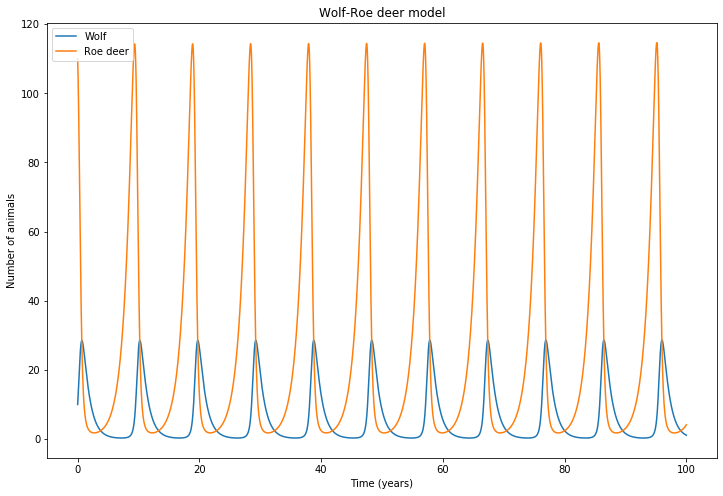

In [120]:
# Plot the figure
t = range(time+1)
t = [step*x for x in t]

plt.figure(figsize=(12,8))
plt.plot(t, pred)
plt.plot(t, prey1)
plt.ylabel('Number of animals')
plt.xlabel('Time (years)')
plt.title('Wolf-Roe deer model')
plt.legend(['Wolf', 'Roe deer'], loc='upper left')
plt.show()

### Wild Boar and Wolf

In [124]:
# Wild boar and wolf
alpha2 = 6.22 # Birth rate prey 
beta2 = 12.4 / 182.75  # Death rate prey
gamma2 = 0.0356 # Birth rate predator
delta2 = 25/26 # Death rate predator

# Time * step = amount of years simulated
time2 = 1000000 
step2 = 0.0001

# Initial populations
init_pred2 = 1
init_prey2 = 500

In [125]:
pred2 = [init_pred2]
prey2 = [init_prey2]

num_pred2 = init_pred2
num_prey2 = init_prey2

for n in range(time):
    dpred2 = pred_eq(gamma2, delta2, num_pred2, num_prey2, step2)
    dprey2 = prey1_eq(alpha2, beta2, num_pred2, num_prey2, step2)
    num_pred2 += dpred2
    num_prey2 += dprey2
    pred2.append(num_pred2)
    prey2.append(num_prey2)

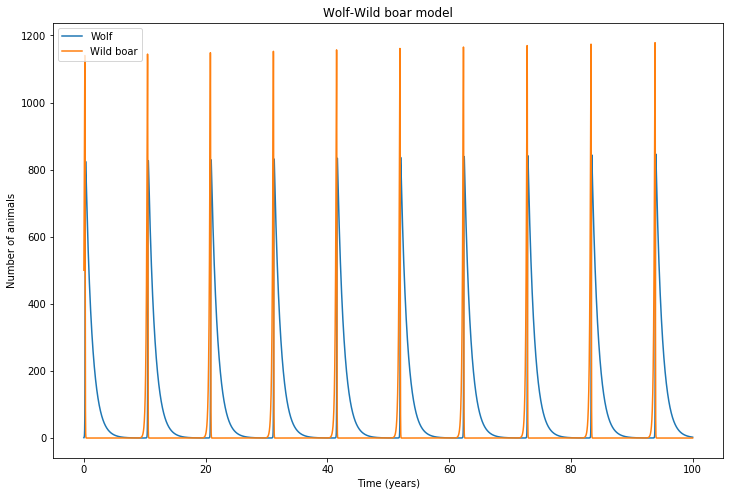

In [127]:
t2 = range(time2+1)
t2 = [step2*x for x in t2]

plt.figure(figsize=(12,8))
plt.plot(t2, pred2)
plt.plot(t2, prey2)
plt.ylabel('Number of animals')
plt.xlabel('Time (years)')
plt.title('Wolf-Wild boar model')
plt.legend(['Wolf', 'Wild boar'], loc='upper left')
plt.show()